# Preprocessing for Apple Stock Dataset

This notebook preprocesses the Apple stock dataset (`apple_stock_dataset.csv`) for time series forecasting, creating a streamlined dataset for ARIMA, SARIMA, Prophet, and LSTM models. It includes data cleaning, feature engineering (lagged prices, moving averages, RSI, volatility, day-of-week), and scaling. The `Date` index is set to date-only (e.g., `2025-07-14`) with a business day frequency (`freq='B'`) by reindexing to fill missing dates (e.g., holidays), ensuring compatibility with ARIMA/SARIMA. The output is a preprocessed CSV file for training and testing, with enhanced visualizations to explore trends, seasonality, distributions, and correlations.

**Features Retained** (required by ARIMA, SARIMA, Prophet, or LSTM):
- Unscaled: `Close`, `Close_Lag1`, `Close_Lag2`, `Close_Lag3`, `Close_Lag4`, `MA7`, `MA20`, `RSI`, `Return`, `Volume`, `Day_of_Week`, `Volatility`.
- Scaled: `Close_Scaled`, `Close_Lag1_Scaled`, `Close_Lag2_Scaled`, `Close_Lag3_Scaled`, `Close_Lag4_Scaled`, `MA7_Scaled`, `MA20_Scaled`, `RSI_Scaled`, `Return_Scaled`, `Volume_Scaled`, `Day_of_Week_Scaled`, `Volatility_Scaled`.

**Features Removed**: `Open`, `High`, `Low`, `MA50`, `LogReturn`, `Year`, `Return_Outlier`, `Month`, `Quarter` (and their scaled versions) as they are not used by any model. `Trend`, `Seasonal`, `Residual` are not included in the dataset (only visualized).

**Visualizations**:
- Close price with Bollinger Bands to show price trends and volatility.
- RSI with overbought/oversold thresholds to assess momentum.
- Return distribution (histogram) to analyze return characteristics.
- Volume with 20-day moving average to highlight trading activity.
- Day-of-week box plot to show price variability by weekday.
- Correlation heatmap to explore feature relationships.
- Volatility over time to visualize the `Volatility` feature.
- Seasonal decomposition to diagnose trend and seasonality.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os

In [3]:


DATA_PATH = "datasets/apple_stock_dataset.csv"
os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
SCALER_PATH="Scalers/"
os.makedirs(os.path.dirname(SCALER_PATH), exist_ok=True)
MODEL_PATH="Prediction Models/"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

In [4]:

# Load existing data
try:
    df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
    df["Date"] = pd.to_datetime(df["Date"], utc=True)
    df["Date"] = df["Date"].dt.tz_localize(None)  # Remove timezone
    df.set_index("Date", inplace=True)
    last_date = df.index[-1]
    print(f"📅 Last entry: {last_date}")
except FileNotFoundError:
    df = pd.DataFrame(columns=["Open", "High", "Low", "Close", "Volume"])
    df.index.name = "Date"
    last_date = datetime(2010, 1, 1)

# Fetch new data
start_date = last_date + timedelta(days=1)
end_date = datetime.now()

if start_date < end_date:
    new_data = yf.download("AAPL", start=start_date.strftime("%Y-%m-%d"),
                           end=end_date.strftime("%Y-%m-%d"),
                           auto_adjust=False, progress=False)

    if not new_data.empty:
        # Flatten multi-index columns if present
        if isinstance(new_data.columns, pd.MultiIndex):
            new_data.columns = new_data.columns.get_level_values(0)

        # Keep only the required columns
        new_data = new_data[["Open", "High", "Low", "Close", "Volume"]]
        new_data.index = new_data.index.tz_localize(None)
        new_data.index.name = "Date"

        combined = pd.concat([df, new_data])
        combined = combined[~combined.index.duplicated(keep='last')]
        combined.sort_index(inplace=True)

        combined.to_csv(DATA_PATH, index_label="Date", float_format="%.7f")
        print(f"✅ Appended {len(new_data)} new rows.")
    else:
        print("✅ No new trading data available.")
else:
    print("⏳ Dataset is already up-to-date.")


📅 Last entry: 2025-07-14 00:00:00
✅ Appended 1 new rows.


In [5]:
# Step 1: Load and inspect the data
df = pd.read_csv('datasets/apple_stock_dataset.csv', parse_dates=['Date'])
print('Dataset Info:')
print(df.info())
print('\nFirst 5 rows:')
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11236 entries, 0 to 11235
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11236 non-null  datetime64[ns]
 1   Open    11236 non-null  float64       
 2   High    11236 non-null  float64       
 3   Low     11236 non-null  float64       
 4   Close   11236 non-null  float64       
 5   Volume  11236 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 526.8 KB
None

First 5 rows:
                 Date      Open      High       Low     Close     Volume
0 1980-12-12 05:00:00  0.098835  0.099264  0.098835  0.098835  469033600
1 1980-12-15 05:00:00  0.094108  0.094108  0.093678  0.093678  175884800
2 1980-12-16 05:00:00  0.087232  0.087232  0.086802  0.086802  105728000
3 1980-12-17 05:00:00  0.088951  0.089381  0.088951  0.088951   86441600
4 1980-12-18 05:00:00  0.091530  0.091959  0.091530  0.091530   734496

In [6]:
# Step 2: Handle missing values and anomalies
print('\nMissing Values:')
print(df.isna().sum())
# Forward fill, backward fill, and interpolate
df_numeric = df.select_dtypes(include=[np.number])
df[df_numeric.columns] = df_numeric.ffill().bfill().interpolate(method='linear')
# Replace zero volume with mean volume
df.loc[df['Volume'] == 0, 'Volume'] = int(df['Volume'].mean())



Missing Values:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [7]:
# Step 3: Set Date as index (only date, with business day frequency)
print('Available columns:', df.columns.tolist())  # Debug: Confirm column names
df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce').dt.date
df.set_index('Date', inplace=True)
# Reindex to a complete business day sequence
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
df = df.reindex(date_range)
# Fill missing values for numerical columns
df = df.ffill().bfill().interpolate(method='linear')
# Replace zero volume with mean volume (if needed after reindexing)
df.loc[df['Volume'] == 0, 'Volume'] = int(df['Volume'].mean()) if 'Volume' in df.columns else 0
df.index = pd.DatetimeIndex(df.index, freq='B')
df.index.name = 'Date'  # Ensure index name is 'Date'


Available columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


In [8]:
# Step 4: Check for data continuity
print('\nDuplicate Dates:', df.index.duplicated().sum())
df = df[~df.index.duplicated(keep='first')]



Duplicate Dates: 0


In [9]:
# Step 5: Feature selection
df = df[['Close', 'Volume']]


In [10]:
# Step 6: Feature engineering
# Lagged features
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)
df['Close_Lag4'] = df['Close'].shift(4)
# Moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
# Returns
df['Return'] = df['Close'].pct_change()
# Volatility (20-day rolling standard deviation of returns)
df['Volatility'] = df['Return'].rolling(window=20).std()
# Manual RSI calculation (14-day period)
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI'] = calculate_rsi(df, period=14)
# Seasonal features
df['Day_of_Week'] = pd.to_datetime(df.index).dayofweek


In [11]:
# Step 7: Drop rows with NaN from feature engineering
df = df.dropna()


In [12]:
# Step 8: Normalize/scale features (for LSTM)
scaler = MinMaxScaler()
numerical_columns = ['Close', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag4', 'MA7', 'MA20', 'Return', 'RSI', 'Volume', 'Volatility']
scaled_data = scaler.fit_transform(df[numerical_columns])
scaled_df = pd.DataFrame(scaled_data, columns=[f'{col}_Scaled' for col in numerical_columns], index=df.index)
# Scale seasonal features separately
seasonal_scaler = MinMaxScaler()
seasonal_columns = ['Day_of_Week']
seasonal_scaled = seasonal_scaler.fit_transform(df[seasonal_columns])
seasonal_scaled_df = pd.DataFrame(seasonal_scaled, columns=[f'{col}_Scaled' for col in seasonal_columns], index=df.index)
# Combine original and scaled features
df = pd.concat([df, scaled_df, seasonal_scaled_df], axis=1)


In [13]:
# Step 9: Save scalers
with open('Scalers/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('Scalers/seasonal_scaler.pkl', 'wb') as f:
    pickle.dump(seasonal_scaler, f)


In [14]:
close_scaler = MinMaxScaler()
close_scaler.fit(df[['Close']])
with open('Scalers/close_scaler.pkl', 'wb') as f:
    pickle.dump(close_scaler, f)


In [15]:
# Step 10: Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print('\nTrain size:', len(train), 'Test size:', len(test))



Train size: 9289 Test size: 2323


In [16]:
# Step 11: Save preprocessed data
train.to_csv('datasets/preprocessed_apple_stock_train.csv')
test.to_csv('datasets/preprocessed_apple_stock_test.csv')
print('\nPreprocessed data saved as: preprocessed_apple_stock_train.csv, preprocessed_apple_stock_test.csv')



Preprocessed data saved as: preprocessed_apple_stock_train.csv, preprocessed_apple_stock_test.csv


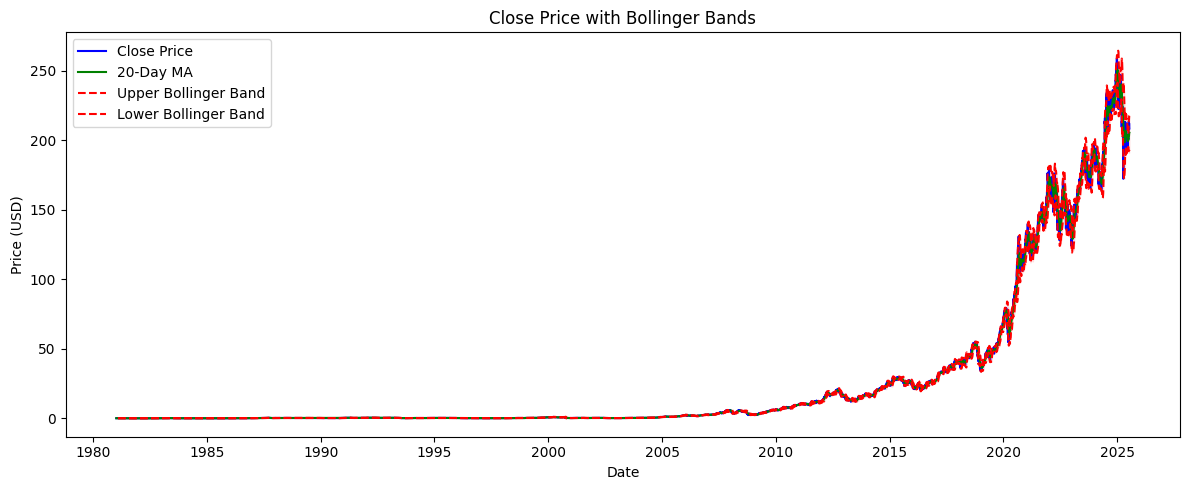

In [17]:
# Step 12: Visualizations
# A. Close price with Bollinger Bands
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['MA20'], label='20-Day MA', color='green')
upper_band = df['MA20'] + 2 * df['Close'].rolling(window=20).std()
lower_band = df['MA20'] - 2 * df['Close'].rolling(window=20).std()
plt.plot(upper_band, label='Upper Bollinger Band', color='red', linestyle='--')
plt.plot(lower_band, label='Lower Bollinger Band', color='red', linestyle='--')
plt.fill_between(df.index, lower_band, upper_band, color='red', alpha=0.1)
plt.title('Close Price with Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()


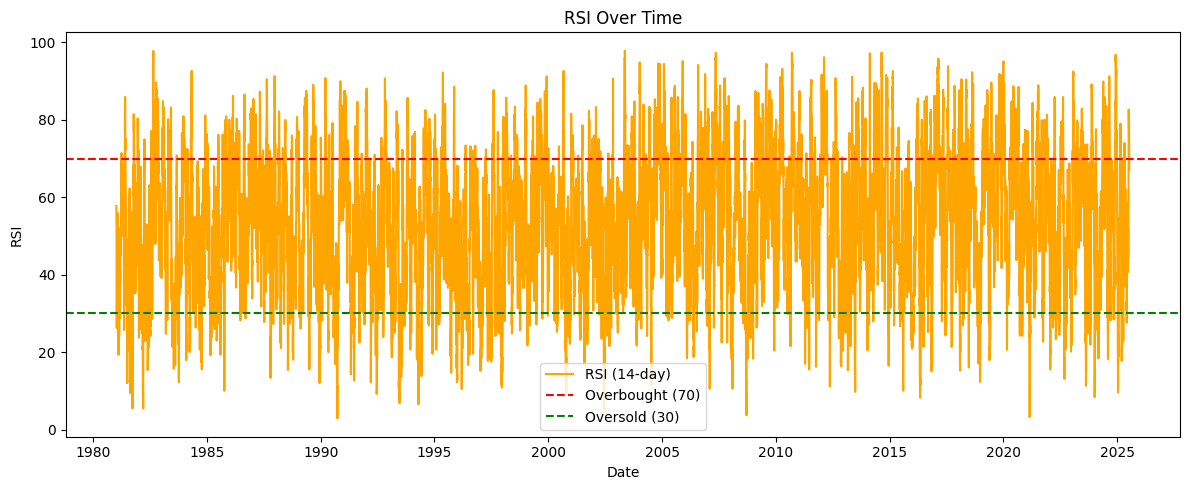

In [18]:
# B. RSI with overbought/oversold thresholds
plt.figure(figsize=(12, 5))
plt.plot(df['RSI'], label='RSI (14-day)', color='orange')
plt.title('RSI Over Time')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.legend()
plt.tight_layout()
plt.show()


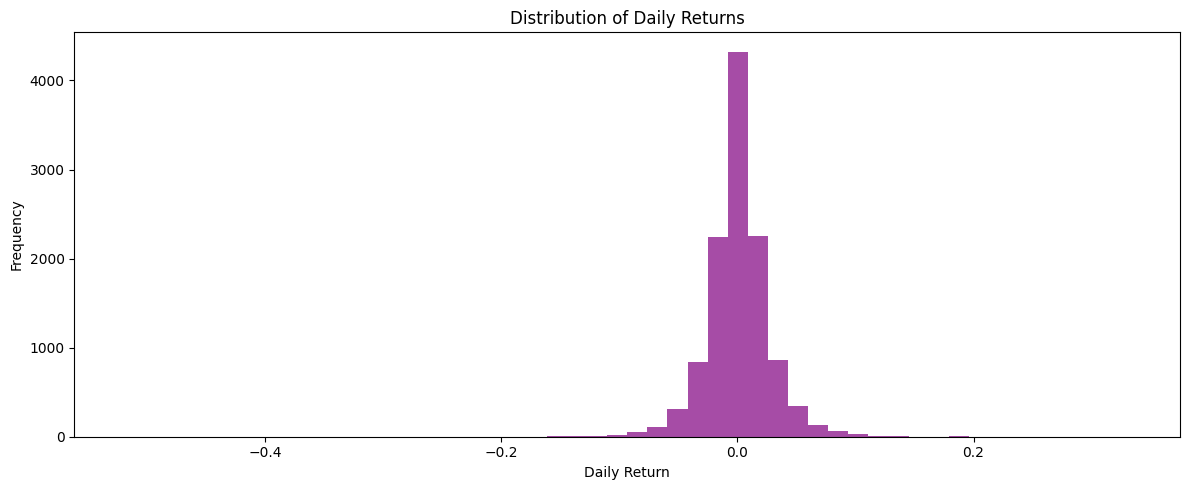

In [19]:
# C. Return distribution (histogram)
plt.figure(figsize=(12, 5))
plt.hist(df['Return'], bins=50, color='purple', alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


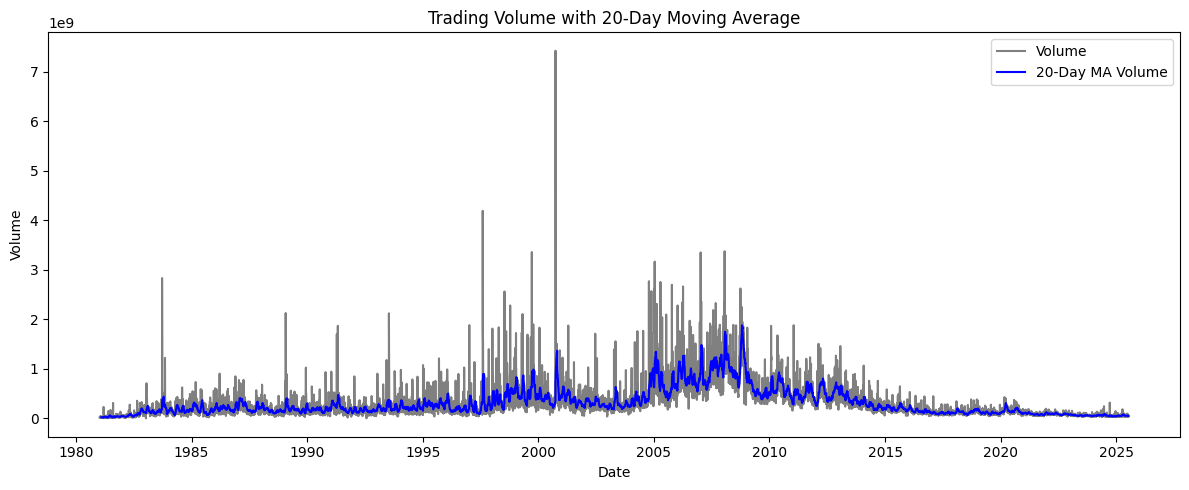

In [20]:
# D. Volume with 20-day moving average
plt.figure(figsize=(12, 5))
plt.plot(df['Volume'], label='Volume', color='gray')
plt.plot(df['Volume'].rolling(window=20).mean(), label='20-Day MA Volume', color='blue')
plt.title('Trading Volume with 20-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1200x500 with 0 Axes>

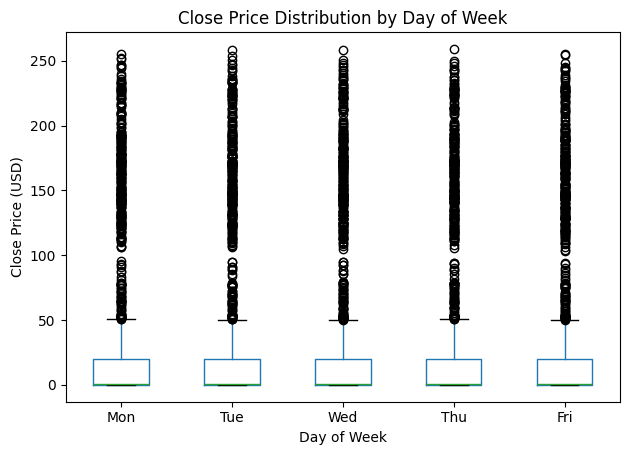

In [21]:
# E. Day-of-week box plot
plt.figure(figsize=(12, 5))
df.boxplot(column='Close', by='Day_of_Week', grid=False)
plt.title('Close Price Distribution by Day of Week')
plt.suptitle('')  # Remove default title
plt.xlabel('Day of Week')
plt.ylabel('Close Price (USD)')
plt.xticks(ticks=range(1, 6), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.tight_layout()
plt.show()


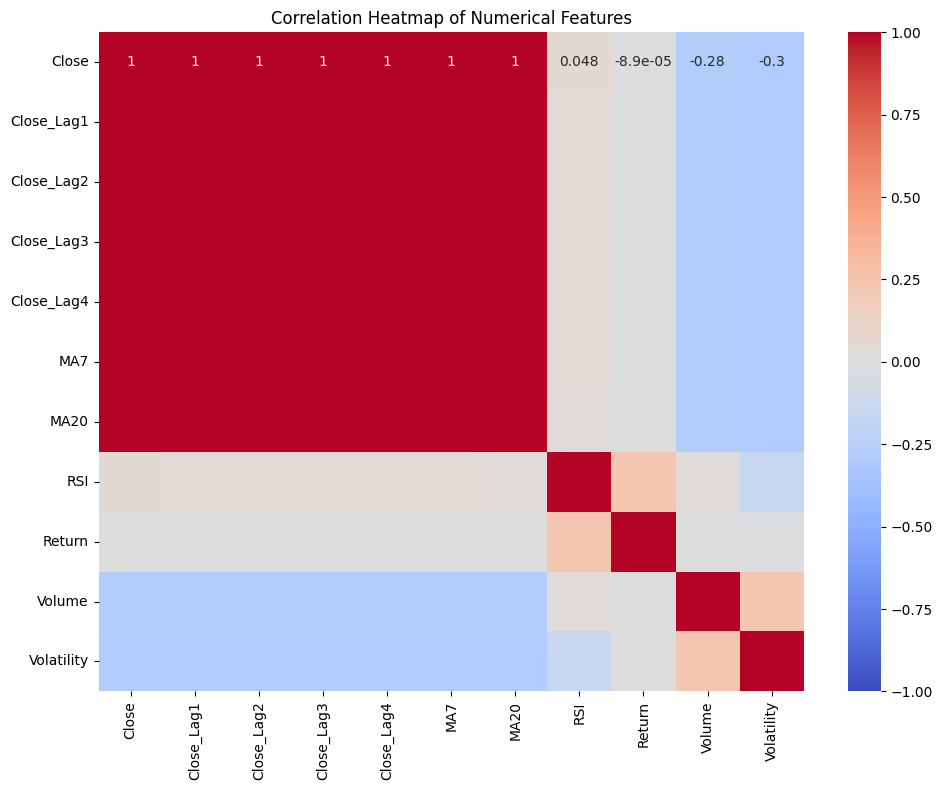

In [22]:
# F. Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df[['Close', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag4', 'MA7', 'MA20', 'RSI', 'Return', 'Volume', 'Volatility']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


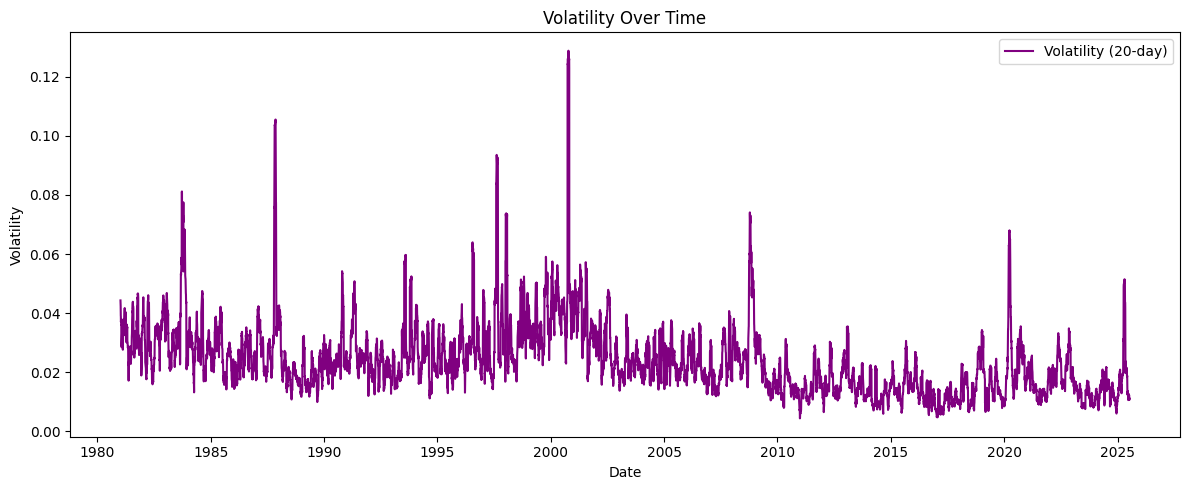

In [23]:
# G. Volatility over time
plt.figure(figsize=(12, 5))
plt.plot(df['Volatility'], label='Volatility (20-day)', color='purple')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()


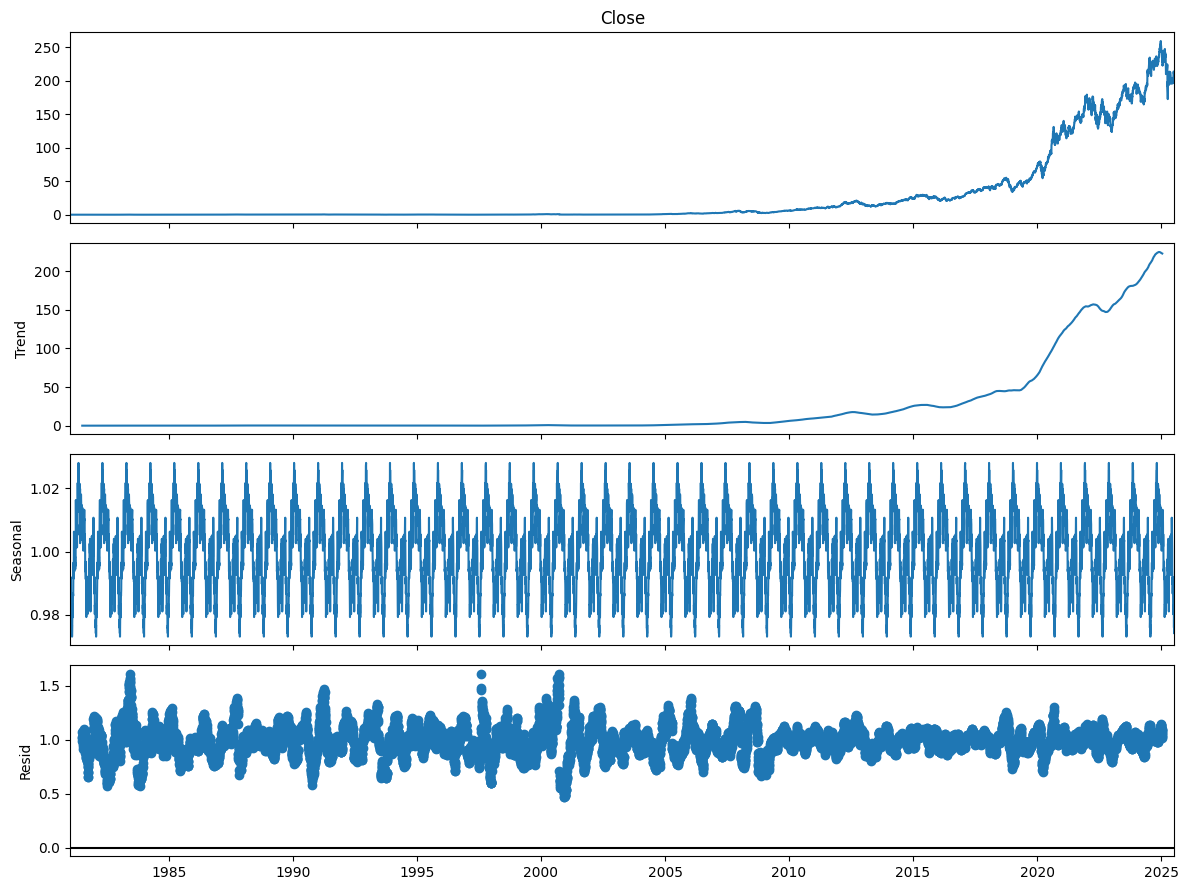

In [24]:
# H. Seasonal decomposition (252-day period, approximately one trading year)
decomp = seasonal_decompose(df['Close'], model='multiplicative', period=252)
fig = decomp.plot()
fig.set_size_inches(12, 9)
plt.tight_layout()
plt.show()


In [25]:
# Step 13: Final check
print('Preprocessed DataFrame head:')
print(df.head())
print('\nColumns in preprocessed dataset:', list(df.columns))
print('\nIndex frequency:', df.index.freq)


Preprocessed DataFrame head:
               Close      Volume  Close_Lag1  Close_Lag2  Close_Lag3  \
Date                                                                   
1981-01-09  0.109577  21504000.0    0.103992    0.106140    0.110867   
1981-01-12  0.108718  23699200.0    0.109577    0.103992    0.106140   
1981-01-13  0.104851  23049600.0    0.108718    0.109577    0.103992   
1981-01-14  0.105281  14291200.0    0.104851    0.108718    0.109577   
1981-01-15  0.107429  14067200.0    0.105281    0.104851    0.108718   

            Close_Lag4       MA7      MA20    Return  Volatility  ...  \
Date                                                              ...   
1981-01-09    0.116024  0.111788  0.107794  0.053715    0.044286  ...   
1981-01-12    0.110867  0.110560  0.108546 -0.007842    0.042280  ...   
1981-01-13    0.106140  0.108595  0.109449 -0.035571    0.039164  ...   
1981-01-14    0.103992  0.107061  0.110265  0.004098    0.039032  ...   
1981-01-15    0.109577  0.10

## Notes
- **Input**: Assumes `apple_stock_dataset.csv` is in the `datasets` directory with columns: `Date`, `Open`, `High`, `Low`, `Close`, `Volume`. The `Date` column is processed to date-only with a business day frequency (`freq='B'`), filling missing dates (e.g., holidays).
- **Output**: Saves `preprocessed_apple_stock_train.csv`, `preprocessed_apple_stock_test.csv`, and `close_scaler.pkl` with 24 columns. The `Date` index has `freq='B'`.
- **Features Retained**:
  - Unscaled: `Close`, `Close_Lag1`, `Close_Lag2`, `Close_Lag3`, `Close_Lag4`, `MA7`, `MA20`, `RSI`, `Return`, `Volume`, `Day_of_Week`, `Volatility`.
  - Scaled: `Close_Scaled`, `Close_Lag1_Scaled`, `Close_Lag2_Scaled`, `Close_Lag3_Scaled`, `Close_Lag4_Scaled`, `MA7_Scaled`, `MA20_Scaled`, `RSI_Scaled`, `Return_Scaled`, `Volume_Scaled`, `Day_of_Week_Scaled`, `Volatility_Scaled`.
- **Features Removed**: `Open`, `High`, `Low`, `MA50`, `LogReturn`, `Year`, `Return_Outlier`, `Month`, `Quarter` (and their scaled versions) as they are not used by ARIMA, SARIMA, Prophet, or LSTM. `Trend`, `Seasonal`, `Residual` are not included in the dataset (only visualized).
- **Usage**:
  - **ARIMA/SARIMA**: Use `Close` for univariate modeling.
  - **Prophet**: Use `Close` (as `y`) and regressors (`RSI`, `MA7`, `MA20`, `Volume`, `Day_of_Week`, `Volatility`).
  - **LSTM**: Use scaled features (`Close_Scaled`, `Close_Lag1_Scaled`, `Close_Lag2_Scaled`, `Close_Lag3_Scaled`, `Close_Lag4_Scaled`, `RSI_Scaled`, `MA7_Scaled`, `MA20_Scaled`, `Return_Scaled`, `Volume_Scaled`, `Day_of_Week_Scaled`, `Volatility_Scaled`).
- **Dependencies**: Install `pandas`, `numpy`, `scikit-learn`, `statsmodels`, `matplotlib`, `seaborn` via `pip install pandas numpy scikit-learn statsmodels matplotlib seaborn`.
- **Visualizations**: Includes Bollinger Bands for price and volatility, RSI for momentum, return histogram for distribution, volume with moving average, day-of-week box plot for weekly patterns, correlation heatmap for feature relationships, volatility plot, and seasonal decomposition for time series structure.
- **Customization**: If additional features (e.g., `Open`, `High`, `Low`) are needed, modify Step 5 to include them (`df = df[['Close', 'Volume', 'Open', 'High', 'Low']]`) and update `numerical_columns` in Step 8.